Set DATE-AVG to '2022-07-29T12:12:49.654' from MJD-AVG.
Set DATE-END to '2022-07-29T12:20:47.457' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.384256 from OBSGEO-[XYZ].
Set OBSGEO-H to 1707958593.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-29T12:12:49.654' from MJD-AVG.
Set DATE-END to '2022-07-29T12:20:47.457' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.384256 from OBSGEO-[XYZ].
Set OBSGEO-H to 1707958593.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


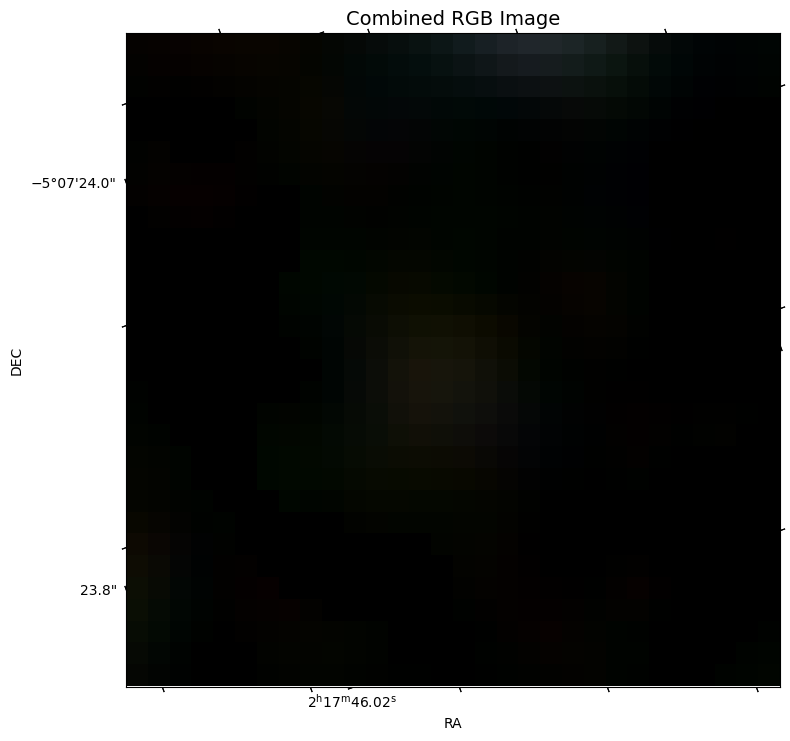

In [14]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

# File paths for the long wavelength images (red, green, blue channels)
b_path = r'c:\Users\Saskia.Hagan-Fellow\OneDrive - ESA\Documents\JWST_DATA_PRIMER\primer_uds2_tile22\psf_matched_jw01837-o022_t024_nircam_f277w.fits'
g_path = r'c:\Users\Saskia.Hagan-Fellow\OneDrive - ESA\Documents\JWST_DATA_PRIMER\primer_uds2_tile22\psf_matched_jw01837-o022_t024_nircam_f356w.fits'
r_path = r'c:\Users\Saskia.Hagan-Fellow\OneDrive - ESA\Documents\JWST_DATA_PRIMER\primer_uds2_tile22\reproject_jw01837-o022_t024_nircam_f444w.fits'

# File paths for the short wavelength images (red, green, blue channels)
r_short_filename = r'c:\Users\Saskia.Hagan-Fellow\OneDrive - ESA\Documents\JWST_DATA_PRIMER\primer_uds2_tile22\psf_matched_jw01837-o022_t024_nircam_f200w.fits'
g_short_filename = r'c:\Users\Saskia.Hagan-Fellow\OneDrive - ESA\Documents\JWST_DATA_PRIMER\primer_uds2_tile22\psf_matched_jw01837-o022_t024_nircam_f150w.fits'
b_short_filename = r'c:\Users\Saskia.Hagan-Fellow\OneDrive - ESA\Documents\JWST_DATA_PRIMER\primer_uds2_tile22\psf_matched_jw01837-o022_t024_nircam_f090w.fits'

# Function to subtract background
def subtract_background(data):
    sigma_clip = SigmaClip(sigma=3)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    return data - bkg.background

# Function to create a stamp around the given RA and DEC
def create_stamp(data, wcs, position, size):
    cutout = Cutout2D(data, position=position, size=size, wcs=wcs)
    return cutout.data, cutout.wcs

# Adjust RA and DEC to refine the centering
ra = 34.4416495  # Right Ascension in degrees
dec = -5.1234236  # Declination in degrees
stamp_size = (30, 30)  # Size of the stamp in pixels

# Load and process long wavelength images
blue_data, blue_header = fits.getdata(b_path, header=True)
green_data, green_header = fits.getdata(g_path, header=True)
red_data, red_header = fits.getdata(r_path, header=True)

blue = subtract_background(blue_data)
green = subtract_background(green_data)
red = subtract_background(red_data)

# WCS information
wcs = WCS(red_header)
position = wcs.wcs_world2pix([[ra, dec]], 1)[0]

# Create stamps for each color channel (long wavelength)
red_stamp, red_stamp_wcs = create_stamp(red, wcs, position, stamp_size)
green_stamp, green_stamp_wcs = create_stamp(green, wcs, position, stamp_size)
blue_stamp, blue_stamp_wcs = create_stamp(blue, wcs, position, stamp_size)

# Load and process short wavelength images
blue_short_data, blue_short_header = fits.getdata(b_short_filename, header=True)
green_short_data, green_short_header = fits.getdata(g_short_filename, header=True)
red_short_data, red_short_header = fits.getdata(r_short_filename, header=True)

blue_short = subtract_background(blue_short_data)
green_short = subtract_background(green_short_data)
red_short = subtract_background(red_short_data)

# WCS information for short wavelength
wcs_short = WCS(red_short_header)

# Create stamps for each short wavelength color channel
red_short_stamp, red_short_stamp_wcs = create_stamp(red_short, wcs_short, position, stamp_size)
green_short_stamp, green_short_stamp_wcs = create_stamp(green_short, wcs_short, position, stamp_size)
blue_short_stamp, blue_short_stamp_wcs = create_stamp(blue_short, wcs_short, position, stamp_size)

# Combine the color channels into a single RGB image
combined_red = red_short_stamp + red_stamp
combined_green = green_short_stamp + green_stamp
combined_blue = blue_short_stamp + blue_stamp

# Create RGB image
combined_rgb = make_lupton_rgb(combined_red, combined_green, combined_blue, Q=5, stretch=0.6, minimum=0)

# Plotting the combined RGB image
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': red_stamp_wcs})
ax.imshow(combined_rgb, origin='lower')
ax.set_title('Combined RGB Image', fontsize=14)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# Adjust layout and display
plt.tight_layout()
plt.show()
